#**Clasificación de Lesiones de Piel con el Dataset HAM10000 usando Transfer Learning Y Fine Tunning**

Integrantes:
- Jessica Paola Escobar Pérez
- Camilo Andrés Calderón Carrillo

In [ ]:
#CONEXION AL DRIVE

from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# **INFORMACIÓN DEL DATASET HAM10000**

1) El **dataset original** de HAM10000 se puede descargar mediante el enlace: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000 y el **artículo** que lo sustenta se puede encontrar en: https://www.nature.com/articles/sdata2018161

2) El **dataset con los datos divididos** en entrenamiento, validación y prueba se puede descargar del siguiente enlace, proporcionado por los autores de este proyecto: https://drive.google.com/file/d/134k-Pb0hq_V8eYmVegvO6EA6fMATYOai/view

3) El **dataset con los datos dividos y aumentados** se encuentra en el siguiente enlace, proporcionado por los autores de este proyecto: https://drive.google.com/file/d/1PZvfvolBpYTcS1leBEdIRnq3LOEsqRe_/view

Para este proyecto utilizamos el dataset expuesto en el ítem **(3)**.

In [ ]:
#Descomprimir el dataset del Drive

!unzip "drive/My Drive/Colab Notebooks/Ham10000/skin-cancer-mnist-ham10000_split_ag.zip"

Streaming output truncated to the last 5000 lines.
  inflating: skin-cancer-mnist-ham10000_split_ag/image_train/vasc/_22_3807428.jpg  
  inflating: skin-cancer-mnist-ham10000_split_ag/image_train/vasc/_22_3814405.jpg  
  inflating: skin-cancer-mnist-ham10000_split_ag/image_train/vasc/_22_3852236.jpg  
  inflating: skin-cancer-mnist-ham10000_split_ag/image_train/vasc/_22_4067259.jpg  
  inflating: skin-cancer-mnist-ham10000_split_ag/image_train/vasc/_22_4210500.jpg  
  inflating: skin-cancer-mnist-ham10000_split_ag/image_train/vasc/_22_4251661.jpg  
  inflating: skin-cancer-mnist-ham10000_split_ag/image_train/vasc/_22_4414254.jpg  
  inflating: skin-cancer-mnist-ham10000_split_ag/image_train/vasc/_22_4426967.jpg  
  inflating: skin-cancer-mnist-ham10000_split_ag/image_train/vasc/_22_4427994.jpg  
  inflating: skin-cancer-mnist-ham10000_split_ag/image_train/vasc/_22_460100.jpg  
  inflating: skin-cancer-mnist-ham10000_split_ag/image_train/vasc/_22_6015743.jpg  
  inflating: skin-cancer-m

In [ ]:
#Librerias
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (BatchNormalization, Dense, Dropout, Flatten)
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
#MODELO RESNET50 CON TRANSFER LEARNING Y FINE-TUNNING 

#CARGANDO EL MODELO CON LOS PESOS PRE-ENTRENADOS DE IMAGENET
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3),
     classes=7, pooling='max', classifier_activation='softmax') 

base_model.trainable = True
set_trainable = False

#FINE TUNNING DEL ÚLTIMO BLOQUE CONVOLUCIONAL
for layer in base_model.layers:
  if layer.name == 'conv4_block4_1_conv':
    set_trainable = True
  if set_trainable: 
    layer.trainable = True
  else:
    layer.trainable = False

base_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
#PLANTEAMIENTO DEL MODELO SECUENCIAL Y ADICIÓN DE LAS ÚLTIMAS CAPAS DE SALIDA
model = Sequential()
model.add(base_model)
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(7, activation="softmax")) #FUNCIÓN DE ACTIVACIÓN SOFTMAX, OUTPUT 7 CLASES 

model.compile(Adam(0.001), loss="categorical_crossentropy", metrics=[categorical_accuracy])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1

In [ ]:
#CARGAR LOS DATOS
train_dir='/content/skin-cancer-mnist-ham10000_split_ag/image_train'
val_dir='/content/skin-cancer-mnist-ham10000_split_ag/image_val'
test_dir='/content/skin-cancer-mnist-ham10000_split_ag/image_test'

IMAGE_SHAPE = (224, 224, 3)
batch_size = 32

data_generator = ImageDataGenerator()

train_flow_param = {
    "directory": train_dir,
    "batch_size": batch_size,
    "target_size": IMAGE_SHAPE[:2],
}
train_flow = data_generator.flow_from_directory(**train_flow_param)

val_flow_param = {
    "directory": val_dir,
    "batch_size": batch_size,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": False 
}
val_flow = data_generator.flow_from_directory(**val_flow_param)

test_flow_param = {
    "directory": test_dir,
    "target_size": IMAGE_SHAPE[:2],
    "batch_size" : 1,
    "shuffle": False 
}
test_flow = data_generator.flow_from_directory(**test_flow_param)

Found 39430 images belonging to 7 classes.
Found 993 images belonging to 7 classes.
Found 993 images belonging to 7 classes.


In [ ]:
#PARAMETROS PARA EL ENTRENAMIENTO

filepath = "model.h5"

checkpoint_param = {
    "filepath": filepath,
    "monitor": "val_categorical_accuracy",
    "verbose": 1,
    "save_best_only": True,
    "mode": "max"
}
checkpoint = ModelCheckpoint(**checkpoint_param)

lr_decay_params = {
    "monitor": "val_loss",
    "factor": 0.5,
    "patience": 2,
    "min_lr": 1e-5
}
lr_decay = ReduceLROnPlateau(**lr_decay_params)

In [ ]:
#ENTRENAMIENTO

fit_params = {
    "generator": train_flow,
    "steps_per_epoch": train_flow.n // batch_size,
    "epochs": 10,
    "verbose": 1,
    "validation_data": val_flow,
    "validation_steps": val_flow.n // batch_size,
    "callbacks": [checkpoint, lr_decay]
}
print("Training the model...")

history = model.fit_generator(**fit_params)

print("Done!")

Training the model...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
1232/1232 [==============================] - ETA: 0s - loss: 0.7234 - categorical_accuracy: 0.7382
Epoch 00001: val_categorical_accuracy improved from -inf to 0.87903, saving model to model.h5
1232/1232 [==============================] - 193s 157ms/step - loss: 0.7234 - categorical_accuracy: 0.7382 - val_loss: 0.3273 - val_categorical_accuracy: 0.8790
Epoch 2/10
1232/1232 [==============================] - ETA: 0s - loss: 0.3527 - categorical_accuracy: 0.8686
Epoch 00002: val_categorical_accuracy improved from 0.87903 to 0.90423, saving model to model.h5
1232/1232 [==============================] - 175s 142ms/step - loss: 0.3527 - categorical_accuracy: 0.8686 - val_loss: 0.2728 - val_categorical_accuracy: 0.9042
Epoch 3/10
1232/1232 [==============================] - ETA: 0s - loss: 0.2261 - categorical_accuracy: 0.9176
Epoch 00003: val_categorical_accuracy did not improve from 

In [ ]:
#Evaluar el modelo con categorical accuracy y f1_score en la validacion
y_val_true = val_flow.classes
y_val_pred = np.argmax(model.predict_generator(val_flow, steps=len(val_flow)), axis=1)

_, val_acc = model.evaluate_generator(val_flow, steps=len(val_flow))
val_precision_score = precision_score(y_val_true, y_val_pred, average="weighted")
val_f1_score = f1_score(y_val_true, y_val_pred, average="weighted")
val_recall_score = recall_score(y_val_true, y_val_pred, average='weighted')

print("Validation accuracy: {:.4f}".format(val_acc))
print("Validation Precision: {:.4f}".format(val_precision_score))
print("Validation F1 score: {:.4f}".format(val_f1_score))
print("Validation Recall score: {:.4f}".format(val_recall_score))

Validation accuracy: 0.9134
Validation Precision: 0.9078
Validation F1 score: 0.9087
Validation Recall score: 0.9134


In [ ]:
#GENERADOR PARA EL TEST TIME AUGMENTATION
data_generator_v = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10.,
        fill_mode='reflect',
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [ ]:
#TEST TIME AUGMENTATION EN LA VALIDACION

from tqdm import tqdm
tta_steps = 10
predictions = []
val_flow = data_generator_v.flow_from_directory(val_dir, batch_size=32, shuffle=False)
for i in tqdm(range(tta_steps)):
    #preds = model.predict_generator(val_flow, steps=len(val_flow))
    preds = model.predict_generator(val_flow, steps = len(val_flow))
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

np.mean(np.equal(y_val_true, np.argmax(pred, axis=-1)))

  0%|          | 0/10 [00:00<?, ?it/s]

Found 993 images belonging to 7 classes.


100%|██████████| 10/10 [03:26<00:00, 20.62s/it]


0.9144008056394763

In [ ]:
#Evaluar el modelo con categorical accuracy y f1_score en el test

y_test_true = test_flow.classes
y_test_pred = np.argmax(model.predict_generator(test_flow, steps=len(test_flow)), axis=1)

_, test_acc = model.evaluate_generator(test_flow, steps=len(test_flow))
test_precision_score = precision_score(y_test_true, y_test_pred, average="weighted")
test_f1_score = f1_score(y_test_true, y_test_pred, average="weighted")
test_recall_score = recall_score(y_test_true, y_test_pred, average='weighted')

print("Test accuracy: {:.4f}".format(test_acc))
print("Test Precision: {:.4f}".format(test_precision_score))
print("Test F1 score: {:.4f}".format(test_f1_score))
print("Test Recall score: {:.4f}".format(test_recall_score))

Test accuracy: 0.9033
Test Precision: 0.9016
Test F1 score: 0.9021
Test Recall score: 0.9033


In [ ]:
#TEST TIME AUGMENTATION EN EL TEST

from tqdm import tqdm
tta_steps = 10
predictions = []
test_flow = data_generator_v.flow_from_directory(test_dir, batch_size=32, shuffle=False)
for i in tqdm(range(tta_steps)):
    #preds = model.predict_generator(val_flow, steps=len(val_flow))
    preds = model.predict_generator(test_flow, steps = len(test_flow))
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

np.mean(np.equal(y_test_true, np.argmax(pred, axis=-1)))

  0%|          | 0/10 [00:00<?, ?it/s]

Found 993 images belonging to 7 classes.


100%|██████████| 10/10 [03:32<00:00, 21.20s/it]


0.9083585095669687

In [ ]:
#OBTENER EL HISTORIAL DE LOS DATOS DEL ENTRENAMIENTO

loss_train = history.history["loss"]
acc_train = history.history["categorical_accuracy"]
loss_val = history.history["val_loss"]
acc_val = history.history["val_categorical_accuracy"]
epochs = np.arange(1, len(loss_train) + 1)

print("Loss Train = " + str(loss_train))
print("Acc Train = " + str(acc_train))
print("Loss Val = " + str(loss_val))
print("Acc Val = " + str(acc_val))

Loss Train = [0.7233700156211853, 0.35269486904144287, 0.2261335402727127, 0.15875495970249176, 0.05190293863415718, 0.035547204315662384, 0.01775098405778408, 0.0093525480479002, 0.006530402228236198, 0.003909396938979626]
Acc Train = [0.7382354140281677, 0.8685719966888428, 0.9176100492477417, 0.9429920315742493, 0.9823595285415649, 0.9880197048187256, 0.9944159388542175, 0.9971826076507568, 0.9979694485664368, 0.9989339709281921]
Loss Val = [0.32725679874420166, 0.2727550268173218, 0.33739838004112244, 0.29983681440353394, 0.4100729823112488, 0.4388023614883423, 0.41837307810783386, 0.4659479856491089, 0.45903563499450684, 0.4620193839073181]
Acc Val = [0.8790322542190552, 0.9042338728904724, 0.8921371102333069, 0.9163306355476379, 0.9112903475761414, 0.9052419066429138, 0.9163306355476379, 0.9112903475761414, 0.9153226017951965, 0.9143145084381104]


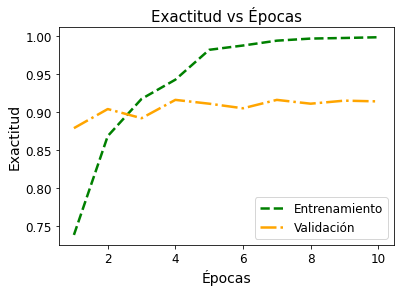

In [ ]:
#PLOTEO DE LOS DATOS DE ACCURACY DEL ENTRENAMIENTO Y DE LA VALIDACION CONTRA NUMERO DE EPOCAS 

import matplotlib.pyplot as plt
import numpy as np

from pylab import *

#GRAFICA ACCURACY
x = np.linspace(1, 10, 10)
#train y val
acctrain = acc_train
accval = acc_val

plt.plot(x, acctrain, label='Entrenamiento',color="green", linestyle="--",linewidth=2.5)
plt.plot(x, accval, label='Validación',color="orange",linestyle="-.", linewidth=2.5)
xticks(fontsize=12)
yticks(fontsize=12)
plt.xlabel('Épocas',fontsize=14)
plt.ylabel('Exactitud',fontsize=14)

plt.title("Exactitud vs Épocas",fontsize=15)

plt.legend(fontsize=12)
plt.savefig("accuracy.pdf", bbox_inches="tight")
plt.savefig("accuracy.png", bbox_inches="tight")
plt.show()

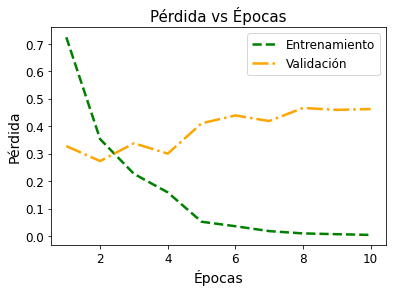

In [ ]:
#GRAFICA LOSS
x = np.linspace(1, 10, 10)

plt.plot(x, loss_train, label='Entrenamiento',color="green", linestyle="--",linewidth=2.5)
plt.plot(x, loss_val, label='Validación',color="orange",linestyle="-.", linewidth=2.5)

xticks(fontsize=12)
yticks(fontsize=12)
plt.xlabel('Épocas',fontsize=14)
plt.ylabel('Pérdida',fontsize=14)

plt.title("Pérdida vs Épocas",fontsize=15)

plt.legend(fontsize=12)
plt.savefig("loss.pdf", bbox_inches="tight")
plt.savefig("loss.png", bbox_inches="tight")
plt.show()

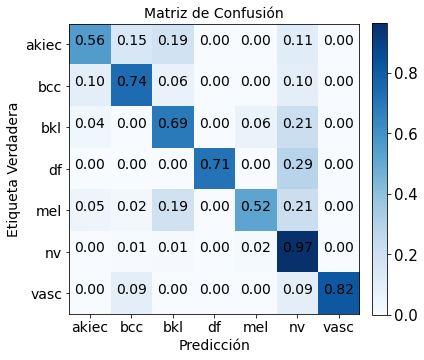

In [ ]:
#MATRIZ DE CONFUSION

import itertools
import matplotlib.pyplot as plt

labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
conf_mat = confusion_matrix(y_test_true, y_test_pred)
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1, keepdims=True)
hide_ticks =True
plt.figure(figsize= (6,6))

def plot_confusion_matrix(cm,
                          normalize=False,
                          cmap=plt.cm.Blues,
                          axis=1): 

    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=15) 
    plt.xticks(range(7), labels, fontsize=14)
    plt.yticks(range(7), labels, fontsize=14)

    fmt = '.2f' if normalize else '.2f'
    thresh = 50
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=14)

    plt.ylabel('Etiqueta Verdadera',fontsize=14)
    plt.xlabel('Predicción',fontsize=14)
    plt.title('Matriz de Confusión',fontsize=14)
    plt.tight_layout()
plot_confusion_matrix(conf_mat)
plt.savefig("confussion.pdf", bbox_inches="tight")
plt.savefig("confussion.png", bbox_inches="tight")